In [1]:
import keras

Using TensorFlow backend.


In [2]:
from keras import backend as K
K.get_session().close()
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [3]:
from keras.layers import Conv2DTranspose ,concatenate, Input,Activation ,Conv2D ,BatchNormalization , Dense ,Dropout ,Flatten ,MaxPool2D ,GlobalMaxPool2D ,GlobalAveragePooling2D
from keras.models import Sequential ,Model
from keras.optimizers import Adam

In [13]:
def get_unet():
    inputs = Input((80, 80, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPool2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(4, (1, 1))(conv9)
    conv11 =GlobalAveragePooling2D()(conv10)
    conv12 =     Activation('softmax') (conv11)
    model = Model(inputs=[inputs], outputs=[conv12])

  

    model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [14]:
model=get_unet()

In [15]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 80, 80, 1)     0                                            
____________________________________________________________________________________________________
conv2d_52 (Conv2D)               (None, 80, 80, 32)    320         input_5[0][0]                    
____________________________________________________________________________________________________
conv2d_53 (Conv2D)               (None, 80, 80, 32)    9248        conv2d_52[0][0]                  
____________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D)  (None, 40, 40, 32)    0           conv2d_53[0][0]                  
___________________________________________________________________________________________

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
gen=image.ImageDataGenerator( rotation_range=15,shear_range=0.1 ,channel_shift_range=0.2 ,width_shift_range=0.4 , height_shift_range=0.25)
gen1=image.ImageDataGenerator()

In [17]:
batch_size=30

train= gen.flow_from_directory('train', target_size=(80,80),
                class_mode='categorical', shuffle=True, batch_size=batch_size, color_mode='grayscale')

Found 5820 images belonging to 4 classes.


In [18]:
val= gen1.flow_from_directory('val', target_size=(80,80),
                class_mode='categorical', shuffle=False, batch_size=batch_size, color_mode='grayscale')

Found 1098 images belonging to 4 classes.


In [19]:
from keras.optimizers import Adam
model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
batch_size=30
model.fit_generator(train, steps_per_epoch=5820 /batch_size, epochs=3, 
                            validation_data=val, validation_steps=1098 /batch_size)

Epoch 1/3
194/194 [==============================] - 109s - loss: 2.4167 - acc: 0.2691 - val_loss: 1.3706 - val_acc: 0.2778
Epoch 2/3
194/194 [==============================] - 100s - loss: 1.3579 - acc: 0.3306 - val_loss: 1.4056 - val_acc: 0.2732
Epoch 3/3
194/194 [==============================] - 99s - loss: 1.3510 - acc: 0.3457 - val_loss: 1.3596 - val_acc: 0.2732


In [21]:
model.optimizer.lr=0.1
for i in range (1,4):
    model.fit_generator(train, steps_per_epoch=5820/batch_size, epochs=5, 
                            validation_data=val, validation_steps=1098/batch_size)
    model.save_weights ('unet2{x}.h5'.format(x=i))

Epoch 1/5
194/194 [==============================] - 101s - loss: 1.3475 - acc: 0.3455 - val_loss: 1.3693 - val_acc: 0.2732
Epoch 2/5
194/194 [==============================] - 100s - loss: 1.3463 - acc: 0.3390 - val_loss: 1.3673 - val_acc: 0.2732
Epoch 3/5
194/194 [==============================] - 98s - loss: 1.3440 - acc: 0.3426 - val_loss: 1.3775 - val_acc: 0.2732
Epoch 4/5
194/194 [==============================] - 98s - loss: 1.3437 - acc: 0.3469 - val_loss: 1.3999 - val_acc: 0.2559
Epoch 5/5
194/194 [==============================] - 98s - loss: 1.3441 - acc: 0.3479 - val_loss: 1.3524 - val_acc: 0.2750
Epoch 1/5
194/194 [==============================] - 100s - loss: 1.3407 - acc: 0.3546 - val_loss: 1.3832 - val_acc: 0.2732
Epoch 2/5
194/194 [==============================] - 95s - loss: 1.3363 - acc: 0.3478 - val_loss: 1.3406 - val_acc: 0.3588
Epoch 3/5
194/194 [==============================] - 99s - loss: 1.3333 - acc: 0.3601 - val_loss: 1.3470 - val_acc: 0.3242
Epoch 4/5
194

In [22]:
model.optimizer.lr=0.01
for i in range (4,7):
    model.fit_generator(train, steps_per_epoch=5820/batch_size, epochs=5, 
                            validation_data=val, validation_steps=1098/batch_size)
    model.save_weights ('unet2{x}.h5'.format(x=i))

Epoch 1/5
194/194 [==============================] - 101s - loss: 1.2619 - acc: 0.4256 - val_loss: 1.3342 - val_acc: 0.2933
Epoch 2/5
194/194 [==============================] - 98s - loss: 1.2426 - acc: 0.4328 - val_loss: 1.3958 - val_acc: 0.3379
Epoch 3/5
194/194 [==============================] - 96s - loss: 1.2546 - acc: 0.4277 - val_loss: 1.2989 - val_acc: 0.3251
Epoch 4/5
194/194 [==============================] - 95s - loss: 1.2361 - acc: 0.4330 - val_loss: 1.3090 - val_acc: 0.3215
Epoch 5/5
194/194 [==============================] - 96s - loss: 1.2275 - acc: 0.4500 - val_loss: 1.2883 - val_acc: 0.2942
Epoch 1/5
194/194 [==============================] - 101s - loss: 1.2116 - acc: 0.4574 - val_loss: 1.2862 - val_acc: 0.2914
Epoch 2/5
194/194 [==============================] - 96s - loss: 1.2293 - acc: 0.4443 - val_loss: 1.3279 - val_acc: 0.3060
Epoch 3/5
194/194 [==============================] - 95s - loss: 1.2139 - acc: 0.4593 - val_loss: 1.2845 - val_acc: 0.3242
Epoch 4/5
194/

In [23]:
model.optimizer.lr=0.001
for i in range (7,10):
    model.fit_generator(train, steps_per_epoch=5820/batch_size, epochs=5, 
                            validation_data=val, validation_steps=1098/batch_size)
    model.save_weights ('unet2{x}.h5'.format(x=i))

Epoch 1/5
194/194 [==============================] - 99s - loss: 1.1675 - acc: 0.4918 - val_loss: 1.3741 - val_acc: 0.3980
Epoch 2/5
194/194 [==============================] - 94s - loss: 1.1541 - acc: 0.5015 - val_loss: 1.3456 - val_acc: 0.3579
Epoch 3/5
194/194 [==============================] - 98s - loss: 1.1597 - acc: 0.5017 - val_loss: 1.3260 - val_acc: 0.3597
Epoch 4/5
194/194 [==============================] - 97s - loss: 1.1421 - acc: 0.5125 - val_loss: 1.3637 - val_acc: 0.3679
Epoch 5/5
194/194 [==============================] - 97s - loss: 1.1354 - acc: 0.5084 - val_loss: 1.3396 - val_acc: 0.3707
Epoch 1/5
194/194 [==============================] - 99s - loss: 1.1257 - acc: 0.5158 - val_loss: 1.4280 - val_acc: 0.3361
Epoch 2/5
194/194 [==============================] - 95s - loss: 1.1077 - acc: 0.5229 - val_loss: 1.3847 - val_acc: 0.3834
Epoch 3/5
194/194 [==============================] - 100s - loss: 1.1061 - acc: 0.5266 - val_loss: 1.3962 - val_acc: 0.3434
Epoch 4/5
194/1

In [24]:
model.optimizer.lr=0.0001
for i in range (10,13):
    model.fit_generator(train, steps_per_epoch=5820/batch_size, epochs=5, 
                            validation_data=val, validation_steps=1098/batch_size)
    model.save_weights ('unet2{x}.h5'.format(x=i))

Epoch 1/5
194/194 [==============================] - 101s - loss: 1.0676 - acc: 0.5436 - val_loss: 1.4540 - val_acc: 0.3233
Epoch 2/5
194/194 [==============================] - 94s - loss: 1.0513 - acc: 0.5483 - val_loss: 1.5143 - val_acc: 0.3570
Epoch 3/5
194/194 [==============================] - 96s - loss: 1.0363 - acc: 0.5509 - val_loss: 1.4850 - val_acc: 0.2878
Epoch 4/5
194/194 [==============================] - 98s - loss: 1.0259 - acc: 0.5655 - val_loss: 1.5087 - val_acc: 0.3333
Epoch 5/5
194/194 [==============================] - 96s - loss: 1.0390 - acc: 0.5565 - val_loss: 1.4643 - val_acc: 0.3434
Epoch 1/5
194/194 [==============================] - 98s - loss: 1.0159 - acc: 0.5689 - val_loss: 1.4664 - val_acc: 0.3461
Epoch 2/5
194/194 [==============================] - 99s - loss: 1.0406 - acc: 0.5485 - val_loss: 1.4621 - val_acc: 0.3470
Epoch 3/5
194/194 [==============================] - 99s - loss: 1.0080 - acc: 0.5596 - val_loss: 1.4893 - val_acc: 0.3597
Epoch 4/5
194/1

In [25]:
model.optimizer.lr=0.00001
for i in range (13,16):
    model.fit_generator(train, steps_per_epoch=5820/batch_size, epochs=5, 
                            validation_data=val, validation_steps=1098/batch_size)
    model.save_weights ('unet2{x}.h5'.format(x=i))

Epoch 1/5
194/194 [==============================] - 105s - loss: 1.0182 - acc: 0.5541 - val_loss: 1.4759 - val_acc: 0.3543
Epoch 2/5
194/194 [==============================] - 100s - loss: 0.9710 - acc: 0.5830 - val_loss: 1.4959 - val_acc: 0.3188
Epoch 3/5
194/194 [==============================] - 100s - loss: 0.9754 - acc: 0.5840 - val_loss: 1.5510 - val_acc: 0.3479
Epoch 4/5
194/194 [==============================] - 96s - loss: 0.9713 - acc: 0.5830 - val_loss: 1.5199 - val_acc: 0.3288
Epoch 5/5
194/194 [==============================] - 98s - loss: 0.9806 - acc: 0.5771 - val_loss: 1.5130 - val_acc: 0.3352
Epoch 1/5
194/194 [==============================] - 101s - loss: 0.9798 - acc: 0.5854 - val_loss: 1.5430 - val_acc: 0.3443
Epoch 2/5
194/194 [==============================] - 98s - loss: 0.9646 - acc: 0.5868 - val_loss: 1.4947 - val_acc: 0.3497
Epoch 3/5
194/194 [==============================] - 100s - loss: 0.9604 - acc: 0.5864 - val_loss: 1.4786 - val_acc: 0.3260
Epoch 4/5
1

In [28]:
model.optimizer.lr=0.00001
for i in range (20,30):
    model.fit_generator(train, steps_per_epoch=5820/batch_size, epochs=5, 
                            validation_data=val, validation_steps=1098/batch_size)
    model.save_weights ('unet2{x}.h5'.format(x=i))

Epoch 1/5
194/194 [==============================] - 106s - loss: 0.8679 - acc: 0.6280 - val_loss: 1.6881 - val_acc: 0.3215
Epoch 2/5
194/194 [==============================] - 98s - loss: 0.8766 - acc: 0.6332 - val_loss: 1.5544 - val_acc: 0.3224
Epoch 3/5
194/194 [==============================] - 98s - loss: 0.8787 - acc: 0.6239 - val_loss: 1.6611 - val_acc: 0.2914
Epoch 4/5
194/194 [==============================] - 99s - loss: 0.8714 - acc: 0.6311 - val_loss: 1.7233 - val_acc: 0.2942
Epoch 5/5
194/194 [==============================] - 99s - loss: 0.8760 - acc: 0.6259 - val_loss: 1.6395 - val_acc: 0.3151
Epoch 1/5
194/194 [==============================] - 105s - loss: 0.8628 - acc: 0.6369 - val_loss: 1.6311 - val_acc: 0.3024
Epoch 2/5
194/194 [==============================] - 99s - loss: 0.8689 - acc: 0.6376 - val_loss: 1.9184 - val_acc: 0.2951
Epoch 3/5
194/194 [==============================] - 98s - loss: 0.8469 - acc: 0.6440 - val_loss: 1.6552 - val_acc: 0.2905
Epoch 4/5
194/

KeyboardInterrupt: 

In [77]:
model.load_weights ('unet20.h5')

In [78]:
test = gen1.flow_from_directory('test', target_size=(160,320),
                class_mode='categorical', shuffle=False, batch_size=1 ,color_mode='grayscale')

Found 238 images belonging to 2 classes.


In [79]:
pre=model.predict_generator(test,238)

In [80]:
files = test.filenames

In [81]:
mistake=0
doubt=0
file=[]
file1=[]
correct=0
num=0
for x in pre :
    
    if x[0]<0.8 and x[0]>0.2: 
        doubt+=1
        print (x , "doubt")
        file1.append (files[num])
    else:
        if num<120:
            if x[0]<0.8: 
                mistake+=1
                print (x,num)
                file.append (files[num])
            else : correct+=1
        else:
            if x[1]<0.8: 
                mistake+=1
                print (x,num) 
                file.append (files[num])
            else : correct+=1
    num+=1
    
all=correct+mistake

[ 0.12662113  0.87337893] 2
[ 0.41719675  0.58280325] doubt
[ 0.58013731  0.41986269] doubt
[ 0.29842135  0.70157862] doubt
[ 0.76593715  0.23406281] doubt
[ 0.24181375  0.75818622] doubt
[ 0.74857968  0.25142026] doubt
[ 0.05592058  0.9440794 ] 22
[ 0.42306682  0.57693315] doubt
[ 0.32064241  0.67935759] doubt
[ 0.60170525  0.39829469] doubt
[ 0.67085344  0.32914653] doubt
[ 0.32562113  0.67437893] doubt
[ 0.74275118  0.25724882] doubt
[ 0.53710419  0.46289587] doubt
[ 0.70246029  0.29753968] doubt
[ 0.48040923  0.51959068] doubt
[ 0.18063843  0.81936157] 72
[ 0.41487718  0.58512276] doubt
[ 0.78687656  0.21312338] doubt
[ 0.57032067  0.42967936] doubt
[ 0.73228389  0.26771611] doubt
[ 0.73341888  0.26658115] doubt
[ 0.72163099  0.27836904] doubt
[ 0.59391421  0.40608585] doubt
[ 0.0432528   0.95674717] 118
[ 0.03540029  0.96459973] 119
[ 0.71973956  0.28026041] doubt
[ 0.26434126  0.73565876] doubt
[ 0.65566319  0.34433681] doubt
[ 0.21196854  0.78803152] doubt
[ 0.31923649  0.680763

In [82]:
correct/all

0.9705882352941176

In [83]:
doubt/all

0.16666666666666666

In [84]:
mistake

6

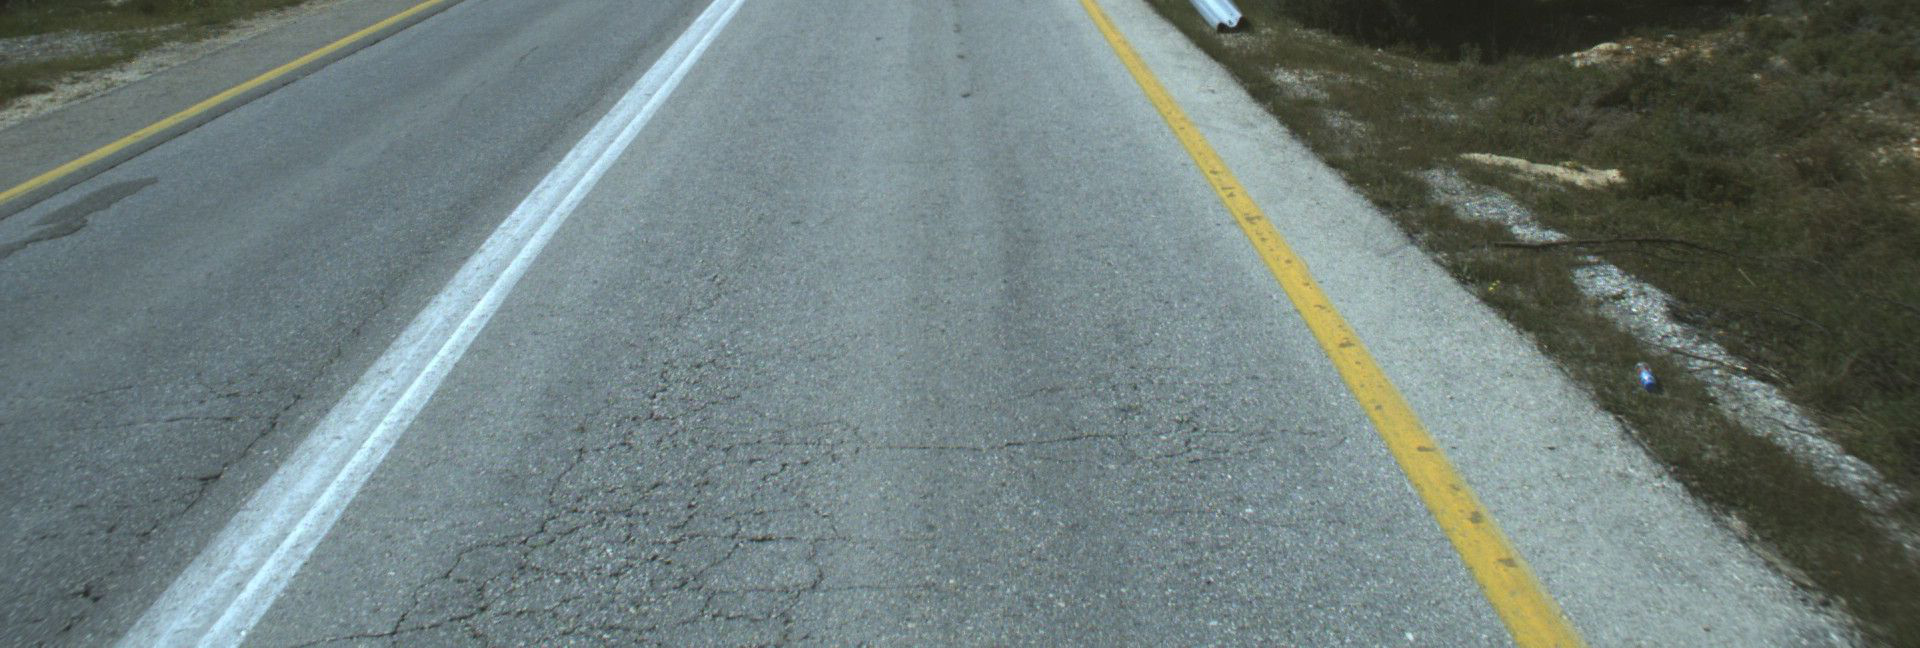

In [85]:
image.load_img ('test/'+files[120])

In [86]:
test = gen1.flow_from_directory('test', target_size=(160,320),
                class_mode=None, shuffle=False, batch_size=1 , color_mode='grayscale')

Found 238 images belonging to 2 classes.


In [87]:
import numpy as np
test1=np.concatenate([test.next() for i in range(test.samples)])

In [88]:
from matplotlib import pyplot as plt

def plot(img):
    plt.imshow(to_plot(img))


def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
def to_plot(img):
    if K.image_dim_ordering() == 'tf':
        return np.rollaxis(img, 0, 1).astype(np.uint8)
    else:
        return np.rollaxis(img, 0, 3).astype(np.uint8)

In [89]:
%matplotlib inline

In [90]:
from keras import backend as K
l =model.layers
conv_fn = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[-3].output])

In [117]:
pic=128

In [118]:
pre [pic]

array([ 0.01005412,  0.98994583], dtype=float32)

In [119]:

inp = np.expand_dims(test1[pic], 0)
conv = conv_fn([inp,0])
conv=conv[0]
print (conv.shape)
show=np.swapaxes(conv,2,3)
show=np.swapaxes(show,1,2)
show=show[0]
print (show.shape)

(1, 160, 320, 2)
(2, 160, 320)


In [120]:
show=show[1]
print (show.shape)

(160, 320)


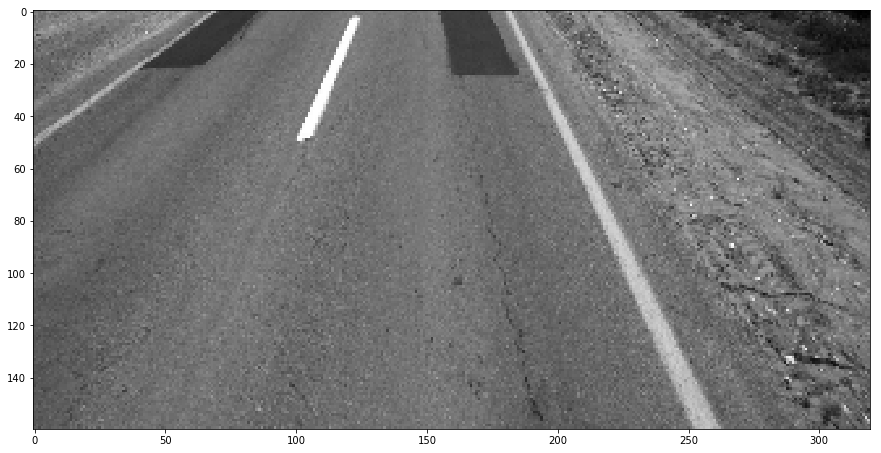

In [121]:
plt.figure(figsize=(15,15))
plt.imshow (x ,cmap="gray")

In [122]:
x=np.reshape (test1[pic] , (160,320))

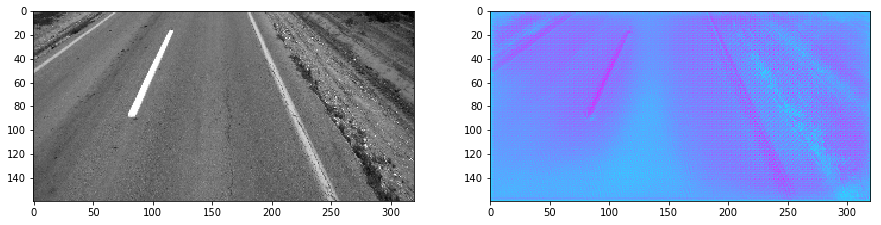

In [123]:
plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow (x ,cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow (show , cmap="cool") 

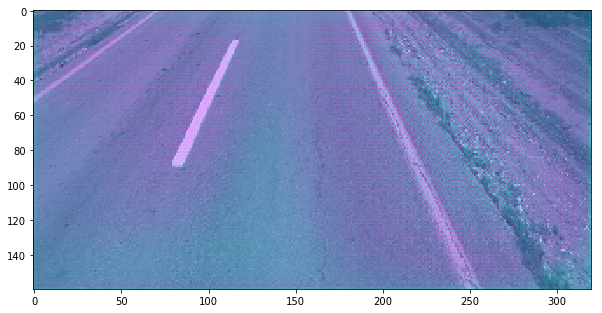

In [124]:
plt.figure(figsize=(10,10))
plt.imshow(x ,cmap="gray", alpha=1)
plt.imshow(show, cmap="cool", alpha=0.5)

In [39]:
x[0][1]**0.1

array([[[ 1.68726838],
        [ 1.69521821],
        [ 1.69084322],
        ..., 
        [ 1.47875762],
        [ 1.51806843],
        [ 1.54400635]],

       [[ 1.69435132],
        [ 1.68726838],
        [ 1.66322684],
        ..., 
        [ 1.6926055 ],
        [ 1.70117736],
        [ 1.58330107]],

       [[ 1.69608116],
        [ 1.67802072],
        [ 1.65802073],
        ..., 
        [ 1.68545508],
        [ 1.68636394],
        [ 1.6926055 ]],

       ..., 
       [[ 1.47875762],
        [ 1.47875762],
        [ 1.45662189],
        ..., 
        [ 1.52493346],
        [ 1.53579164],
        [ 1.52267599]],

       [[ 1.47273338],
        [ 1.47875762],
        [ 1.46647882],
        ..., 
        [ 1.51806843],
        [ 1.52038789],
        [ 1.5315311 ]],

       [[ 1.48168886],
        [ 1.47875762],
        [ 1.48168886],
        ..., 
        [ 1.51806843],
        [ 1.51806843],
        [ 1.52267599]]], dtype=float32)

In [87]:
x=val.next()

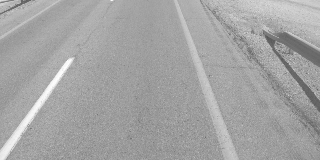

In [94]:
image.array_to_img((x[0][8]/255)**0.5)